In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import date, timedelta

In [3]:
data = pd.read_csv('Nat_Gas.csv', parse_dates=['Dates'])

C:\Users\LOKESH\AppData\Local\Temp\ipykernel_6628\3413558936.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv('Nat_Gas.csv', parse_dates=['Dates'])


In [4]:
data.set_index('Dates', inplace=True)

In [6]:
prices = data['Prices'].values
dates = data.index.values

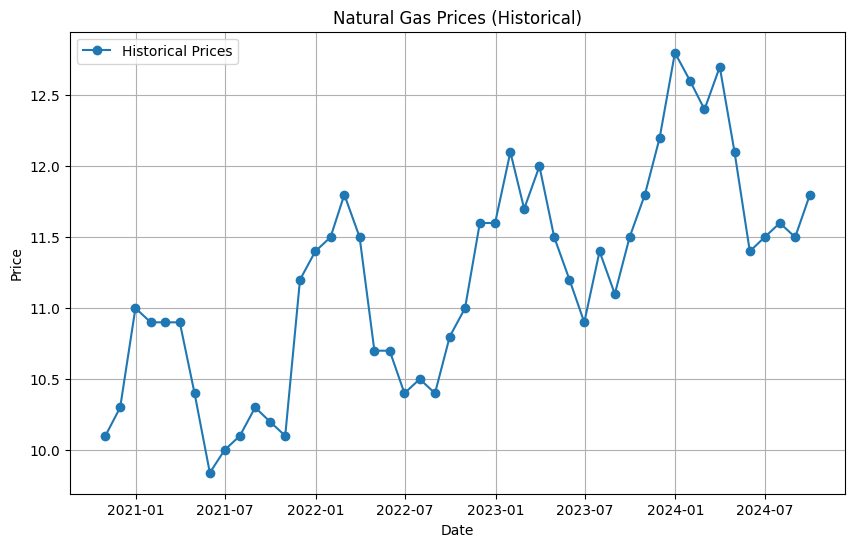

In [28]:
# plot prices against dates
plt.figure(figsize=(10,6))
plt.plot(dates, prices, label='Historical Prices', marker='o')
plt.title('Natural Gas Prices (Historical)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()

In [13]:
# From the plot - we can see the prices have a natural frequency of around a year, but trend upwards. 
# We can do a linear regression to get the trend, and then fit a sin function to the variation in each year.

# First we need the dates in terms of days from the start, to make it easier to interpolate later.


In [14]:
start_date = date(2020,10,31)
end_date = date(2024,9,30)
months = []
year = start_date.year
month = start_date.month + 1

In [15]:
while True:
    current = date(year, month, 1) + timedelta(days=-1)
    months.append(current)
    if current.month == end_date.month and current.year == end_date.year:
        break
    else:
        month = ((month + 1) % 12) or 12
        if month == 1:
            year += 1

In [16]:
days_from_start = [(day - start_date ).days for day in months]

In [17]:
months

[datetime.date(2020, 10, 31),
 datetime.date(2020, 11, 30),
 datetime.date(2020, 12, 31),
 datetime.date(2021, 1, 31),
 datetime.date(2021, 2, 28),
 datetime.date(2021, 3, 31),
 datetime.date(2021, 4, 30),
 datetime.date(2021, 5, 31),
 datetime.date(2021, 6, 30),
 datetime.date(2021, 7, 31),
 datetime.date(2021, 8, 31),
 datetime.date(2021, 9, 30),
 datetime.date(2021, 10, 31),
 datetime.date(2021, 11, 30),
 datetime.date(2021, 12, 31),
 datetime.date(2022, 1, 31),
 datetime.date(2022, 2, 28),
 datetime.date(2022, 3, 31),
 datetime.date(2022, 4, 30),
 datetime.date(2022, 5, 31),
 datetime.date(2022, 6, 30),
 datetime.date(2022, 7, 31),
 datetime.date(2022, 8, 31),
 datetime.date(2022, 9, 30),
 datetime.date(2022, 10, 31),
 datetime.date(2022, 11, 30),
 datetime.date(2022, 12, 31),
 datetime.date(2023, 1, 31),
 datetime.date(2023, 2, 28),
 datetime.date(2023, 3, 31),
 datetime.date(2023, 4, 30),
 datetime.date(2023, 5, 31),
 datetime.date(2023, 6, 30),
 datetime.date(2023, 7, 31),
 date

In [24]:
len(days_from_start)

48

In [19]:
# Simple regression for the trend will fit to a model y = Ax + B. The estimator for the slope is given by \hat{A} = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sum (x_i - \bar{x})^2}, 
# and that for the intercept by \hat{B} = \bar{y} - hat{A} * \xbar

In [20]:
def simple_regression(x, y):
    xbar = np.mean(x)
    ybar = np.mean(y)
    slope = np.sum((x - xbar) * (y - ybar))/ np.sum((x - xbar)**2)
    intercept = ybar - slope*xbar
    return slope, intercept

In [25]:
time = np.array(days_from_start)
slope, intercept = simple_regression(time, prices)

In [26]:
slope, intercept

(0.001282373598760221, 10.29104112595228)

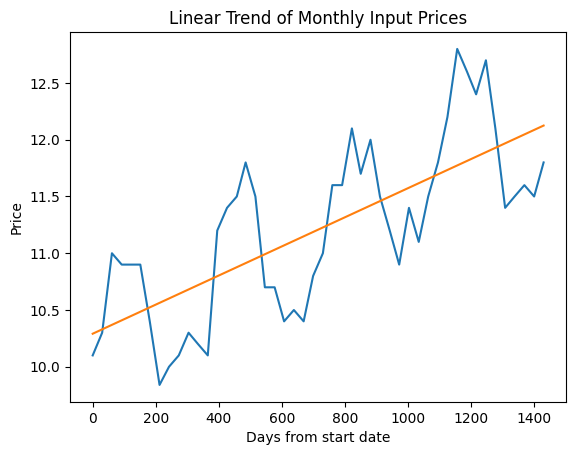

In [27]:
# Plot linear trend
plt.plot(time, prices)
plt.plot(time, time * slope + intercept)
plt.xlabel('Days from start date')
plt.ylabel('Price')
plt.title('Linear Trend of Monthly Input Prices')
plt.show()

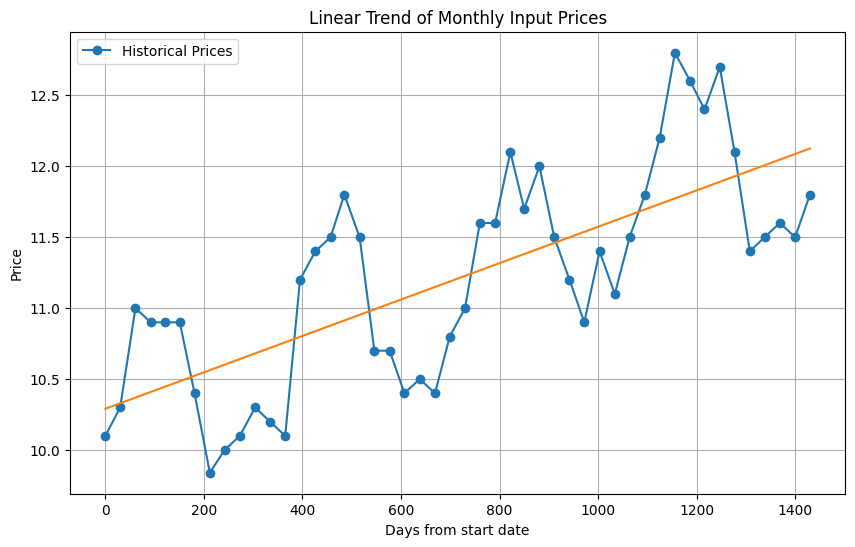

In [31]:
# plot prices against dates
plt.figure(figsize=(10,6))
plt.plot(time, prices, label='Historical Prices', marker='o')
plt.plot(time, time * slope + intercept)
plt.title('Linear Trend of Monthly Input Prices')
plt.xlabel('Days from start date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# From this plot we see the linear trend has been captured. Now to fit the intra-year variation. 
# Given that natural gas is used more in winter, and less in summer, we can guess the frequency of the price movements to be about a year, or 12 months.
# Therefore we have a model y = Asin( kt + z ) with a known frequency.Rewriting y = Acos(z)sin(kt) + Asin(z)cos(kt), 
# we can use bilinear regression, with no intercept, to solve for u = Acos(z), w = Asin(z)

In [35]:
sin_prices = prices - (time * slope + intercept)
sin_time = np.sin(time * 2 * np.pi / (365))
cos_time = np.cos(time * 2 * np.pi / (365))

In [36]:
def bilinear_regression(y, x1, x2):
    # Bilinear regression without an intercept amounts to projection onto the x-vectors
    slope1 = np.sum(y * x1) / np.sum(x1 ** 2)
    slope2 = np.sum(y * x2) / np.sum(x2 ** 2)
    return(slope1, slope2)

In [37]:
slope1, slope2 = bilinear_regression(sin_prices, sin_time, cos_time)

In [38]:
# We now recover the original amplitude and phase shift as A = slope1 ** 2 + slope2 ** 2, z = tan^{-1}(slope2/slope1)
amplitude = np.sqrt(slope1 ** 2 + slope2 ** 2)
shift = np.arctan2(slope2, slope1)

Text(0.5, 1.0, 'Smoothed Estimate of Monthly Input Prices')

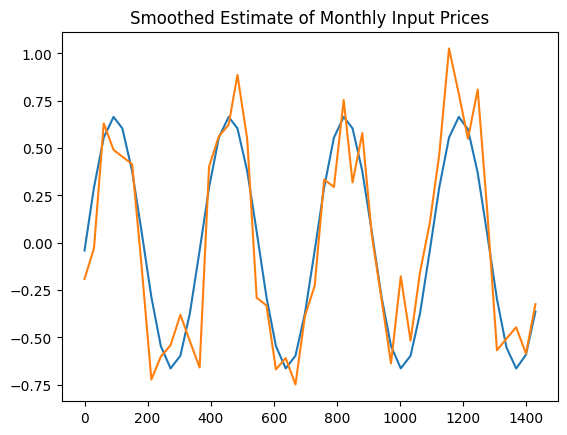

In [39]:
# Plot smoothed estimate of full dataset
plt.plot(time, amplitude * np.sin(time * 2 * np.pi / 365 + shift))
plt.plot(time, sin_prices)
plt.title('Smoothed Estimate of Monthly Input Prices')

In [40]:
# Define the interpolation/extrapolation function
def interpolate(date):
    days = (date - pd.Timestamp(start_date)).days
    if days in days_from_start:
        # Exact match found in the data
        return prices[days_from_start.index(days)]
    else:
        # Interpolate/extrapolate using the sin/cos model
        return amplitude * np.sin(days * 2 * np.pi / 365 + shift) + days * slope + intercept

In [41]:
# Create a range of continuous dates from start date to end date
continuous_dates = pd.date_range(start=pd.Timestamp(start_date), end=pd.Timestamp(end_date), freq='D')

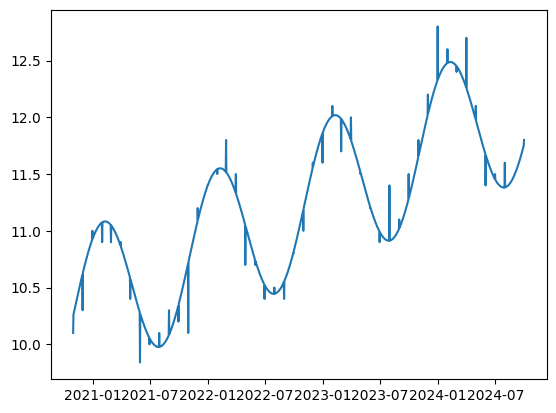

In [42]:
# Plot the smoothed estimate of the full dataset using interpolation
plt.plot(continuous_dates, [interpolate(date) for date in continuous_dates], label='Smoothed Estimate')

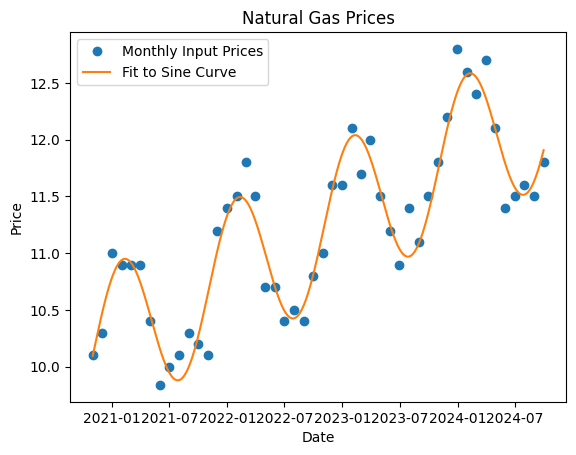

: 

In [43]:
# Fit the monthly input prices to the sine curve
x = np.array(days_from_start)
y = np.array(prices)
fit_amplitude = np.sqrt(slope1 ** 2 + slope2 ** 2)
fit_shift = np.arctan2(slope2, slope1)
fit_slope, fit_intercept = simple_regression(x, y - fit_amplitude * np.sin(x * 2 * np.pi / 365 + fit_shift))
plt.plot(dates, y, 'o', label='Monthly Input Prices')
plt.plot(continuous_dates, fit_amplitude * np.sin((continuous_dates - pd.Timestamp(start_date)).days * 2 * np.pi / 365 + fit_shift) + (continuous_dates - pd.Timestamp(start_date)).days * fit_slope + fit_intercept, label='Fit to Sine Curve')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Natural Gas Prices')
plt.legend()
plt.show()